In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Classification Model

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [3]:
df = pd.read_csv('data/habitat-suitability.csv')

In [4]:
df

,Altitude,Distance_from_Human_Paths,Livestock_Density,Vegetation_Diversity_Index,Water_Source_Availability,Human_Disturbance_Index,Slope,Annual_Rainfall,Bamboo_Coverage,Mean_Annual_Temperature,Suitable
0,2023.988261,434.678578,3.446700,0.008606,0,0.958644,1.902428,481.346699,40.438091,9.787795,1
1,3291.571474,374.299977,2.873850,0.011834,1,0.838599,16.484248,272.127408,55.983789,5.280065,1
2,2810.386672,216.189749,4.991707,0.001131,0,1.140845,29.466434,276.755018,44.974754,6.667004,0
3,2517.048665,339.831903,3.594812,0.021270,1,1.043919,9.966878,553.044339,88.458894,8.003624,1
4,1543.241009,227.141237,3.313984,0.006689,1,1.010359,10.647234,677.418356,7.053957,13.797550,1
...,...,...,...,...,...,...,...,...,...,...,...
99995,2943.070627,486.628948,3.810608,0.004137,0,0.849407,27.083635,280.787687,22.979504,6.265352,1
99996,2914.356369,496.073871,4.235591,0.009070,1,0.847571,10.520047,379.771440,116.050033,5.233896,0
99997,2683.797496,106.722664,4.845199,0.006228,1,0.899508,11.544332,382.667603,71.238266,4.971030,1
99998,2298.783938,529.334414,3.380380,0.009181,0,0.976766,23.171634,504.726645,17.879073,7.906713,1


In [5]:
def classificationModel(labelled_df):

    X = labelled_df.drop('Suitable', axis=1)
    y = labelled_df['Suitable']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    log_reg = LogisticRegression(random_state=42)
    log_reg.fit(X_train_scaled, y_train)

    y_pred = log_reg.predict(X_test_scaled)

    sample_accuracy = accuracy_score(y_test, y_pred)

    return sample_accuracy, log_reg, scaler

### **Baseline Model** (with full information)

In [6]:
baseline_accuracy, _, _ = classificationModel(df)

In [7]:
baseline_accuracy

0.8989333333333334

### **Random Active Learning**

In [8]:
# Average across seeds to get a more robust result:
tot_accuracies = []

for seed in range(1, 11):
    np.random.seed(seed)
    
    accuracies = {}

    # Initialize sample (stratified)
    _, current_sample = train_test_split(df, test_size=50, random_state=42, stratify=df['Suitable'])
    labelled_indexes = current_sample.index.tolist()

    step = 100

    for size in range(50, 5000, step):
        
        # Select labelled data and train model
        labelled_df = df.loc[labelled_indexes]
        sample_acc, model, scaler = classificationModel(labelled_df)

        # Predict on unlabelled data
        unlabelled_df = df.drop(labelled_indexes)
        
        full_X_train_scaled = scaler.fit_transform(unlabelled_df.drop('Suitable', axis=1))

        full_y_pred = model.predict(full_X_train_scaled)
        
        full_acc = accuracy_score(unlabelled_df['Suitable'], full_y_pred)

        # Store accuracies
        accuracies[size] = [sample_acc, full_acc]
        
        # Update sample 
        current_sample = df[~df.index.isin(labelled_indexes)].sample(n=step)

        labelled_indexes.extend(current_sample.index.tolist())

        tot_accuracies.append(accuracies)

In [9]:
list_of_dicts = tot_accuracies

sums = {key: (0, 0) for key in list_of_dicts[0].keys()}
# Initialize a dictionary to hold the count of entries for each key
counts = {key: 0 for key in list_of_dicts[0].keys()}

# Iterate over each dictionary and then each key to accumulate sums and counts
for d in list_of_dicts:
    for key, value_pair in d.items():
        # Sum the values for each key separately
        sums[key] = (sums[key][0] + value_pair[0], sums[key][1] + value_pair[1])
        # Increment the count for each key
        counts[key] += 1

# Calculate the average for each key
averages = {key: ((sums[key][0] / counts[key]), (sums[key][1] / counts[key])) for key in sums.keys()}

In [10]:
accuracies_df = pd.DataFrame(averages).T
accuracies_df.columns = ['Sample Accuracy', 'Full Accuracy']
accuracies_df

,Sample Accuracy,Full Accuracy
50,0.866667,0.890835
150,0.920000,0.882890
250,0.872000,0.888893
350,0.875238,0.890491
450,0.897037,0.892254
550,0.903636,0.894549
650,0.903077,0.894871
750,0.903556,0.894324
850,0.896078,0.893328
950,0.895789,0.893082


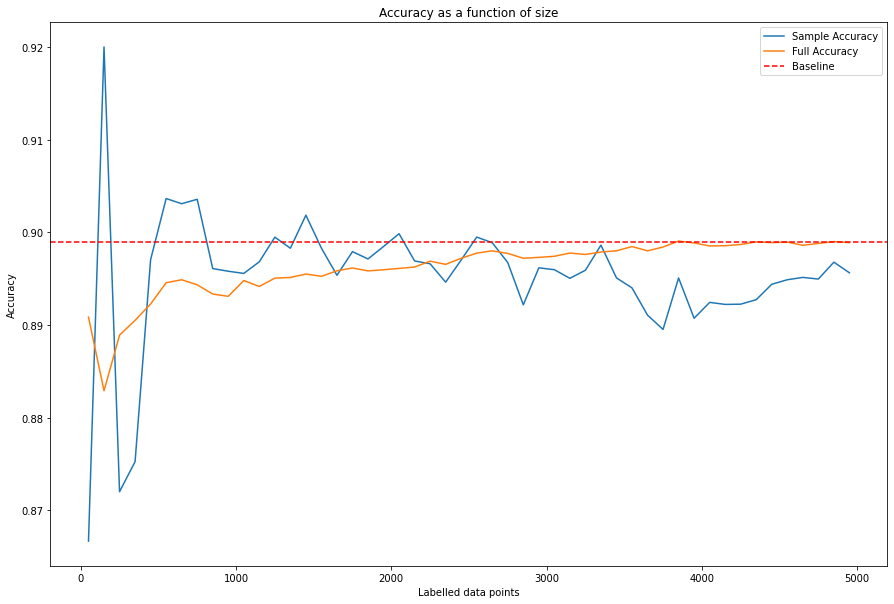

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))

plt.plot(accuracies_df.reset_index()['index'], accuracies_df['Sample Accuracy'], label='Sample Accuracy')
plt.plot(accuracies_df.reset_index()['index'], accuracies_df['Full Accuracy'], label='Full Accuracy')

# Baseline accuracy
plt.axhline(y=baseline_accuracy, color='r', linestyle='--', label='Baseline')

plt.legend()
plt.title('Accuracy as a function of size')
plt.xlabel('Labelled data points')
plt.ylabel('Accuracy')

plt.show()

### **Uncertainty Based Active Learning**

In [12]:
accuracies_u = {}

# Initialize sample (stratified)
_, current_sample = train_test_split(df, test_size=50, random_state=42, stratify=df['Suitable'])
labelled_indexes = current_sample.index.tolist()
step = 100

for size in range(50, 9000, step):
    # Select labelled data and train model
    labelled_df = df.loc[labelled_indexes]
    sample_acc, model, scaler = classificationModel(labelled_df)

    # Predict on unlabelled data
    unlabelled_df = df.drop(labelled_indexes)
    full_X_train_scaled = scaler.fit_transform(unlabelled_df.drop('Suitable', axis=1))
    full_y_pred = model.predict(full_X_train_scaled)
    full_acc = accuracy_score(unlabelled_df['Suitable'], full_y_pred)

    # Store accuracies
    accuracies_u[size] = [sample_acc, full_acc]
    
    # Update sample  -- Uncertainty based
    predicted_proba = model.predict_proba(full_X_train_scaled)
    predicted_proba_df = pd.DataFrame(predicted_proba[:,1], index=unlabelled_df.index)
    predicted_proba_df['uncertainty_diff'] = (0.5 - predicted_proba_df[0]).abs()

    top_50_uncertain_points = predicted_proba_df.nsmallest(step, 'uncertainty_diff')

    # Update labelled_indexes with the indexes of the top 50 uncertain points
    labelled_indexes.extend(top_50_uncertain_points.index.tolist())

In [13]:
accuracies_u_df = pd.DataFrame(accuracies_u).T
accuracies_u_df.columns = ['Sample Accuracy', 'Full Accuracy']
accuracies_u_df

,Sample Accuracy,Full Accuracy
50,0.866667,0.890835
150,0.800000,0.838998
250,0.853333,0.855950
350,0.761905,0.856407
450,0.762963,0.863817
...,...,...
8550,0.771540,0.883062
8650,0.773025,0.882999
8750,0.762286,0.883079
8850,0.779661,0.883269


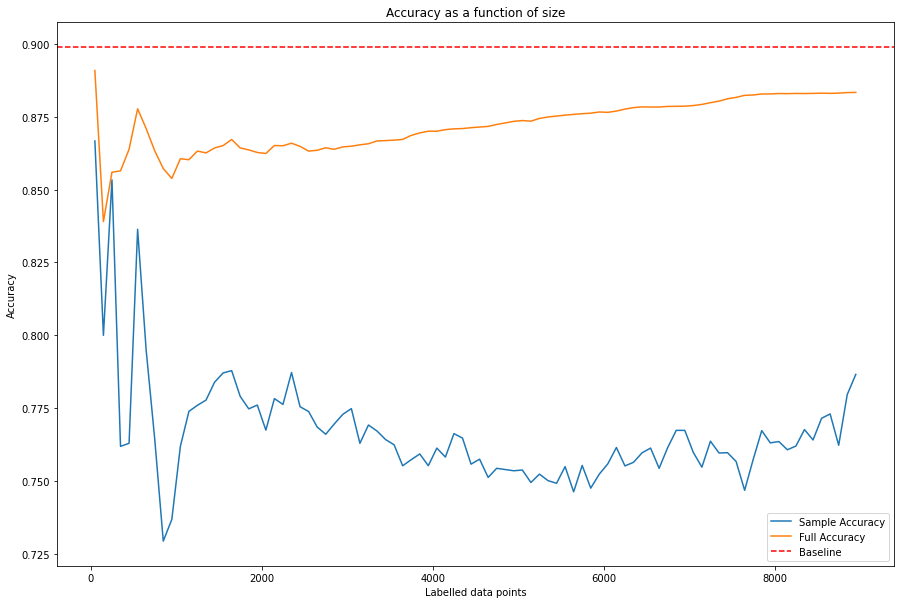

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))

plt.plot(accuracies_u_df.reset_index()['index'], accuracies_u_df['Sample Accuracy'], label='Sample Accuracy')
plt.plot(accuracies_u_df.reset_index()['index'], accuracies_u_df['Full Accuracy'], label='Full Accuracy')

# Baseline accuracy
plt.axhline(y=baseline_accuracy, color='r', linestyle='--', label='Baseline')

plt.legend()
plt.title('Accuracy as a function of size')
plt.xlabel('Labelled data points')
plt.ylabel('Accuracy')

plt.show()

### **Feature Selection and Uncertainty Based Active Learning**

In [15]:
from sklearn.metrics import accuracy_score
from scipy.spatial.distance import cdist

accuracies_uf = {}

# Initialize sample (stratified)
_, current_sample = train_test_split(df, test_size=50, random_state=42, stratify=df['Suitable'])
labelled_indexes = current_sample.index.tolist()
step = 100

for size in range(50, 9000, step):
    
    # Select labelled data and train model
    labelled_df = df.loc[labelled_indexes]
    sample_acc, model, scaler = classificationModel(labelled_df)

    # Predict on unlabelled data
    unlabelled_df = df.drop(labelled_indexes)
    unlabelled_X = unlabelled_df.drop('Suitable', axis=1)
    full_X_train_scaled = scaler.transform(unlabelled_X)
    full_y_pred = model.predict(full_X_train_scaled)
    full_acc = accuracy_score(unlabelled_df['Suitable'], full_y_pred)

    # Store accuracies
    accuracies_uf[size] = [sample_acc, full_acc]
    
    # Uncertainty based selection
    predicted_proba = model.predict_proba(full_X_train_scaled)
    predicted_proba_df = pd.DataFrame(predicted_proba[:,1], index=unlabelled_df.index)
    predicted_proba_df['uncertainty_diff'] = (0.5 - predicted_proba_df[0]).abs()
    uncertain_points = predicted_proba_df.nsmallest(step, 'uncertainty_diff')

    # Dissimilarity based selection
    uncertain_features = unlabelled_X.loc[uncertain_points.index]
    distances = cdist(unlabelled_X, uncertain_features, metric='euclidean')
    mean_distances = distances.mean(axis=1)
    dissimilarity_df = pd.DataFrame(mean_distances, index=unlabelled_df.index, columns=['dissimilarity'])
    dissimilar_points = dissimilarity_df.nlargest(step, 'dissimilarity')

    # Combine uncertain and dissimilar points
    combined_indexes = set(uncertain_points.index.tolist()).union(set(dissimilar_points.index.tolist()))

    # Update labelled_indexes with the combined indexes
    labelled_indexes.extend(combined_indexes)

accuracies_uf_df = pd.DataFrame(accuracies_uf).T
accuracies_uf_df.columns = ['Sample Accuracy', 'Full Accuracy']


In [16]:
accuracies_uf_df

,Sample Accuracy,Full Accuracy
50,0.866667,0.889465
150,0.773333,0.597704
250,0.770370,0.696715
350,0.764103,0.787740
450,0.721569,0.795280
...,...,...
8550,0.777322,0.903606
8650,0.777971,0.904158
8750,0.784718,0.904665
8850,0.781114,0.905441


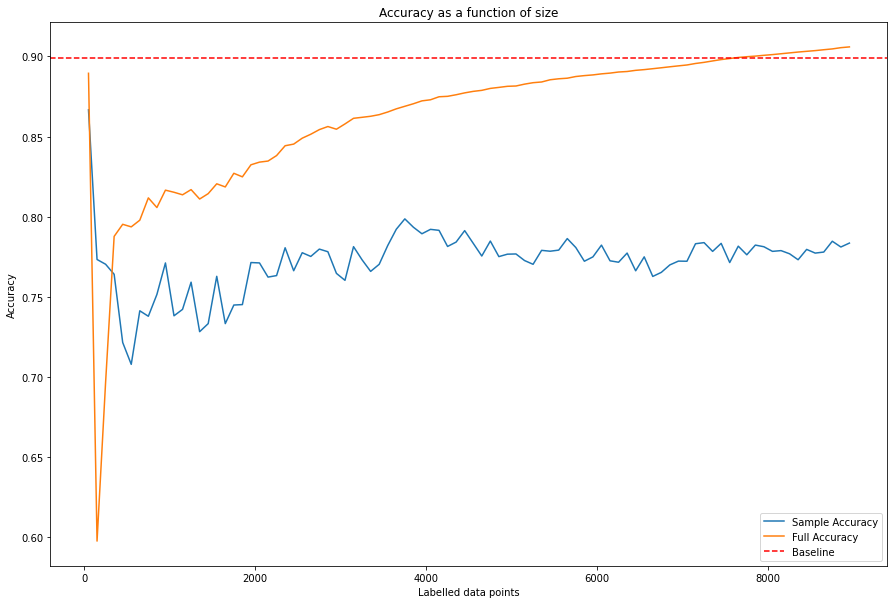

In [17]:
plt.figure(figsize=(15,10))

plt.plot(accuracies_uf_df.reset_index()['index'], accuracies_uf_df['Sample Accuracy'], label='Sample Accuracy')
plt.plot(accuracies_uf_df.reset_index()['index'], accuracies_uf_df['Full Accuracy'], label='Full Accuracy')

# Baseline accuracy
plt.axhline(y=baseline_accuracy, color='r', linestyle='--', label='Baseline')

plt.legend()
plt.title('Accuracy as a function of size')
plt.xlabel('Labelled data points')
plt.ylabel('Accuracy')

plt.show()